In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Add project root to sys.path (one directory up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"Project root: {project_root}")
sys.path.insert(0, project_root)

from models.resnet50_backbone import ResNet50Backbone  # Import your custom model class

Project root: /Users/cola/Desktop/AI/compvis/CV-crowd-flow-estimation-


In [3]:
# Load your model
def load_model(model_path):
    model = ResNet50Backbone()  # Initialize your custom model
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Basic saliency map function
def get_saliency_map(model, image_tensor, target_class=None):
    # Enable gradients for input
    image_tensor.requires_grad_()
    
    # Forward pass
    outputs = model(image_tensor)
    
    # If target class is not specified, use the predicted class
    if target_class is None:
        if isinstance(outputs, tuple):  # Handle if your model returns multiple outputs
            outputs = outputs[0]  # Assuming first output is the class prediction
        target_class = outputs.argmax(dim=1).item()
    
    # Zero gradients
    model.zero_grad()
    
    # Backward pass for the target class
    if isinstance(outputs, tuple):
        outputs = outputs[0]
    
    # Create one-hot encoding for the target class
    one_hot = torch.zeros_like(outputs)
    one_hot[0, target_class] = 1
    
    # Backward pass
    outputs.backward(gradient=one_hot)
    
    # Get gradients and take absolute value
    gradients = image_tensor.grad.data.abs()
    
    # Take maximum across color channels
    saliency, _ = torch.max(gradients, dim=1)
    
    return saliency.squeeze().cpu().numpy()

# Load and preprocess an image
def preprocess_image(image_path, size=(224, 224)):
    # Define preprocessing steps (adapt to match your model's preprocessing)
    preprocess = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        # Use your model's normalization values
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image, input_tensor

# Grad-CAM implementation for ResNet backbone
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.hooks = []
        self.hooks.append(self.target_layer.register_forward_hook(self._forward_hook))
        self.hooks.append(self.target_layer.register_backward_hook(self._backward_hook))
    
    def _forward_hook(self, module, input, output):
        self.activations = output
    
    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image)
        
        # Check if output is a tuple and get the appropriate tensor
        if isinstance(output, tuple):
            output = output[0]  # Adjust based on your model's output structure
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)
        
        # Calculate weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Apply weights to activations
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        
        # Apply ReLU to highlight positive contributions
        cam = torch.relu(cam)
        
        # Normalize
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        
        return cam.detach().cpu().numpy()
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# Main function
def visualize_saliency(model_path, image_path):
    # Load model
    model = load_model(model_path)
    
    # Load and preprocess image
    original_image, input_tensor = preprocess_image(image_path)
    
    # Generate basic saliency map
    saliency_map = get_saliency_map(model, input_tensor.clone())
    
    # For Grad-CAM, find the appropriate layer
    # This depends on your ResNet50Backbone implementation
    # For standard ResNet50, it's typically the last convolutional layer
    # You might need to adjust this for your custom backbone
    target_layer = None
    
    # Try to find the last convolutional layer in your model
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            target_layer = module
    
    # Check if we found a target layer
    if target_layer is not None:
        # Initialize Grad-CAM
        grad_cam = GradCAM(model, target_layer)
        
        # Generate CAM
        cam = grad_cam.generate_cam(input_tensor)
        
        # Resize CAM to match original image dimensions
        from PIL import Image
        cam_image = Image.fromarray(np.uint8(255 * cam))
        cam_image = cam_image.resize((original_image.width, original_image.height), Image.LANCZOS)
        cam_resized = np.array(cam_image) / 255.0
        
        # Create heatmap overlay
        heatmap = plt.cm.jet(cam_resized)[:, :, :3]
        
        # Convert original image to numpy array for blending
        original_np = np.array(original_image) / 255.0
        
        # Overlay heatmap on original image (60% original, 40% heatmap)
        superimposed = 0.6 * original_np + 0.4 * heatmap
        
        # Visualize results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(saliency_map, cmap='hot')
        plt.title('Vanilla Saliency Map')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(superimposed)
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Clean up
        grad_cam.remove_hooks()
    else:
        # If target layer wasn't found, just show saliency map
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='hot')
        plt.title('Saliency Map')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


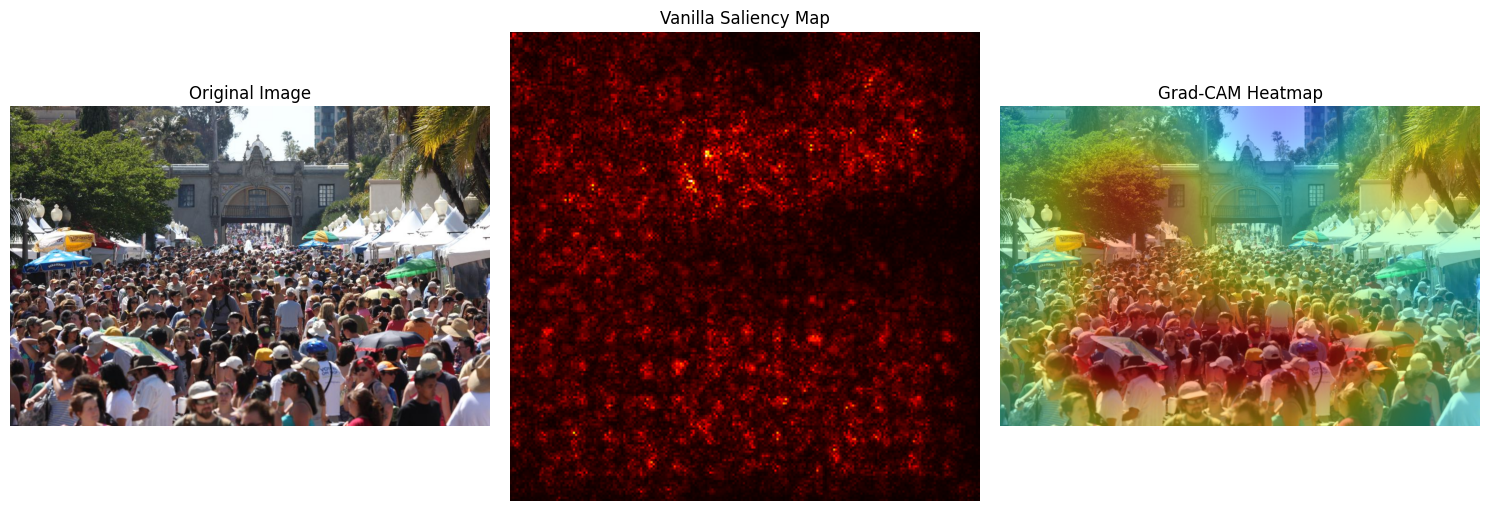

In [16]:
# Example usage
model_path = '../models/part_A_model.pth'
image_path = '../data/ShanghaiTech/part_A/train_data/images/IMG_5.jpg'
visualize_saliency(model_path, image_path)